# ADS 509 Sentiment Assignment
## Conor Fitzpatrick

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [ ]:
# Add any additional import statements you need here




In [7]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/cfitzpatrick/Downloads/M1 Results 3"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "/Users/cfitzpatrick/Downloads/positive-words.txt"
negative_words_file = "/Users/cfitzpatrick/Downloads/negative-words.txt"
tidy_text_file = "/Users/cfitzpatrick/Downloads/tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [11]:
# Read in the lyrics data

def read_lyrics_data(lyrics_folder):
    lyrics_data = defaultdict(dict)
    for artist in os.listdir(lyrics_folder):
        artist_folder = os.path.join(lyrics_folder, artist)
        if os.path.isdir(artist_folder):
            for song in os.listdir(artist_folder):
                song_path = os.path.join(artist_folder, song)
                with open(song_path, 'r', encoding='utf-8') as file:
                    lyrics_data[artist][song] = file.read()
    return lyrics_data

In [24]:
# Read in the twitter data
# Function to read in twitter data and extract the description field
def read_twitter_data(twitter_folder):
    twitter_data = defaultdict(list)
    relevant_files = ['cher_followers_data.txt', 'robynkonichiwa_followers_data.txt']
    for artist_file in relevant_files:
        artist_file_path = os.path.join(twitter_folder, artist_file)
        with open(artist_file_path, 'r', encoding='utf-8', errors='ignore') as file:
            header = next(file)  # Skip the header line
            for line in file:
                fields = line.strip().split('\t')
                if len(fields) > 6:  # Ensure there are enough fields
                    description = fields[6]
                    artist_name = os.path.splitext(artist_file)[0]
                    twitter_data[artist_name].append(description)
    return twitter_data

In [29]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Function to read in the positive and negative words
def read_sentiment_words(positive_words_file, negative_words_file):
    positive_words = set()
    negative_words = set()
    
    with open(positive_words_file, 'r', encoding='utf-8') as file:
        for line in file:
            if not line.startswith(';'):
                positive_words.add(line.strip())
                
    with open(negative_words_file, 'r', encoding='utf-8') as file:
        for line in file:
            if not line.startswith(';'):
                negative_words.add(line.strip())
                
    return positive_words, negative_words

# Read in the positive and negative words
positive_words, negative_words = read_sentiment_words(positive_words_file, negative_words_file)

In [26]:
lyrics_data = read_lyrics_data(os.path.join(data_location, lyrics_folder))
twitter_data = read_twitter_data(os.path.join(data_location, twitter_folder))
positive_words, negative_words = read_sentiment_words(positive_words_file, negative_words_file)

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


Song Sentiment Summary:
robyn: 283
cher: 1244


In [33]:
# your code here

# Function to calculate sentiment score
def calculate_sentiment(text, positive_words, negative_words):
    words = re.findall(r'\b\w+\b', text.lower())
    score = sum(1 for word in words if word in positive_words) - sum(1 for word in words if word in negative_words)
    return score

# Calculate sentiment for each song
song_sentiments = defaultdict(dict)
for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        song_sentiments[artist][song] = calculate_sentiment(lyrics, positive_words, negative_words)

# Summarize song sentiments
song_summary = {artist: sum(sentiments.values()) for artist, sentiments in song_sentiments.items()}

# Print song sentiment summaries
print("Song Sentiment Summary:")
for artist, score in song_summary.items():
    print(f"{artist}: {score}")
    



Song Sentiment Summary:
robyn: 283
cher: 1244


In [34]:

# Find the top 3 and bottom 3 songs for each artist
def find_top_bottom_songs(song_sentiments, n=3):
    sorted_songs = {artist: sorted(songs.items(), key=lambda item: item[1], reverse=True) for artist, songs in song_sentiments.items()}
    top_songs = {artist: songs[:n] for artist, songs in sorted_songs.items()}
    bottom_songs = {artist: songs[-n:] for artist, songs in sorted_songs.items()}
    return top_songs, bottom_songs

top_songs, bottom_songs = find_top_bottom_songs(song_sentiments)

# Print the lyrics and sentiment scores for the top 3 and bottom 3 songs
for artist in top_songs.keys():
    print(f"\nTop 3 songs for {artist}:")
    for song, score in top_songs[artist]:
        print(f"\nSong: {song}, Sentiment Score: {score}")
        print(f"Lyrics:\n{lyrics_data[artist][song]}")
    
    print(f"\nBottom 3 songs for {artist}:")
    for song, score in bottom_songs[artist]:
        print(f"\nSong: {song}, Sentiment Score: {score}")
        print(f"Lyrics:\n{lyrics_data[artist][song]}")



Top 3 songs for robyn:

Song: robyn_loveisfree.txt, Sentiment Score: 102
Lyrics:
"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chic

In [35]:
print("\nAnalysis:")
for artist in top_songs.keys():
    print(f"\nFor {artist}:")
    print(f"The top 3 songs with the highest sentiment scores are: {', '.join([song for song, score in top_songs[artist]])}")
    print(f"The bottom 3 songs with the lowest sentiment scores are: {', '.join([song for song, score in bottom_songs[artist]])}")


Analysis:

For robyn:
The top 3 songs with the highest sentiment scores are: robyn_loveisfree.txt, robyn_showmelove.txt, robyn_ushouldknowbetter114529.txt
The bottom 3 songs with the lowest sentiment scores are: robyn_criminalintent.txt, robyn_dontfuckingtellmewhattodo.txt, robyn_dontfuckingtellmewhattodo114520.txt

For cher:
The top 3 songs with the highest sentiment scores are: cher_perfection.txt, cher_mylove.txt, cher_loveandunderstanding.txt
The bottom 3 songs with the lowest sentiment scores are: cher_dressedtokill.txt, cher_outrageous.txt, cher_iwalkonguildedsplinters.txt


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: It seems Cher has the higher average sentiment per song, with a value of 1244, much higher than Robyn at 283. It would seem Cher has more happy or positive songs. 

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Cher, "Perfection", "My Love", and "Love and Understanding" have the highest sentiment score. The lowest sentiment songs are "Dressed to Kill", "Outrageous", and "I walk on guilded splinters".  As we can see in the lyrics, the positive songs are very much about love and relationships and general romance. The negative sentiment songs are a bit more jaded, and have more negative imagery with smoke and depressing themes etc.



---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: For Robyn, we see some similar themes. The three highest sentiment songs are "Love is Free", "Show me Love", and "u should know better". The first two are a bit obvious, very love-centric. The last song is a bit of a mystery, as looking at the lyrics and it doesn't seem amazingly positive, kind of her teller a lover they could and should have done better. 

The negative songs are "Criminal Intent", "Dont Fucking Tell Me What to Do", and for somereason, the same song again but 114520. I am not sure what happened with that one. But regardless, these negative songs are quite obviously negative, with words like killing very prevalant, and rebellious attitudes present. 

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




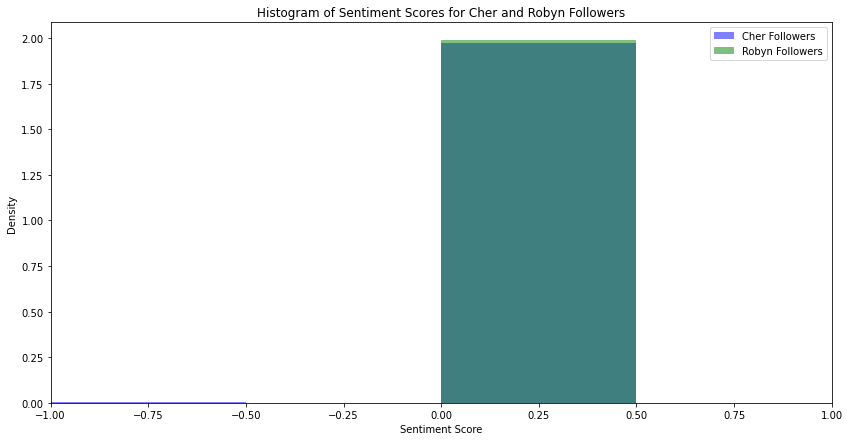

In [58]:

# Convert sentiment lists to numpy arrays
cher_scores = np.array(emoji_sentiments['cher_followers_data'])
robyn_scores = np.array(emoji_sentiments['robynkonichiwa_followers_data'])


# Plot the histograms using matplotlib
plt.figure(figsize=(14, 7))

# Adjusted histogram for Cher's followers
plt.hist(cher_scores, bins=np.arange(-1.5, 2, 0.5), alpha=0.5, color='blue', label='Cher Followers', density=True)

# Adjusted histogram for Robyn's followers
plt.hist(robyn_scores, bins=np.arange(-1.5, 2, 0.5), alpha=0.5, color='green', label='Robyn Followers', density=True)

plt.title('Histogram of Sentiment Scores for Cher and Robyn Followers')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.xlim(-1, 1)
plt.legend()
plt.show()


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [41]:


# Positive and negative emojis 
positive_emojis = set(["😊", "😁", "😍", "👍", "🎉", "❤️", "🤣", "😃", "😄", "😆", "😇", "👏", "🙌", "💕", "🌟"])
negative_emojis = set(["😢", "😞", "😡", "😭", "👎", "😠", "😣", "😖", "😫", "😩", "😤", "😱", "😨", "💔", "😔"])


# Function to calculate emoji sentiment score
def calculate_emoji_sentiment(text, positive_emojis, negative_emojis):
    score = 0
    for char in text:
        if char in positive_emojis:
            score += 1
        elif char in negative_emojis:
            score -= 1
    return score

# Calculate emoji sentiment for each tweet description
emoji_sentiments = defaultdict(list)
for artist, descriptions in twitter_data.items():
    for description in descriptions:
        emoji_sentiments[artist].append(calculate_emoji_sentiment(description, positive_emojis, negative_emojis))

# Summarize emoji sentiments
emoji_summary = {artist: sum(sentiments) / len(sentiments) if sentiments else 0 for artist, sentiments in emoji_sentiments.items()}

# Print emoji sentiment summaries
print("Emoji Sentiment Summary:")
for artist, score in emoji_summary.items():
    print(f"{artist}: {score:.2f}")

# Calculate average sentiment
average_emoji_sentiment = {artist: sum(sentiments) / len(sentiments) if sentiments else 0 for artist, sentiments in emoji_sentiments.items()}



Emoji Sentiment Summary:
cher_followers_data: 0.02
robynkonichiwa_followers_data: 0.01


In [42]:
from collections import Counter

# Count occurrences of each positive and negative emoji in the descriptions
emoji_counts = {artist: Counter() for artist in twitter_data.keys()}

for artist, descriptions in twitter_data.items():
    for description in descriptions:
        for char in description:
            if char in positive_emojis or char in negative_emojis:
                emoji_counts[artist][char] += 1

# Separate counts for positive and negative emojis
positive_emoji_counts = {artist: {emoji: count for emoji, count in counts.items() if emoji in positive_emojis} for artist, counts in emoji_counts.items()}
negative_emoji_counts = {artist: {emoji: count for emoji, count in counts.items() if emoji in negative_emojis} for artist, counts in emoji_counts.items()}


In [43]:
# Function to find the most popular emoji
def most_popular_emoji(emoji_counts):
    if not emoji_counts:
        return None, 0
    most_popular = max(emoji_counts.items(), key=lambda item: item[1])
    return most_popular

# Find the most popular positive and negative emojis for each artist
most_popular_positive = {artist: most_popular_emoji(counts) for artist, counts in positive_emoji_counts.items()}
most_popular_negative = {artist: most_popular_emoji(counts) for artist, counts in negative_emoji_counts.items()}

# Print the results
print("\nMost Popular Positive and Negative Emojis:")
for artist in twitter_data.keys():
    positive_emoji, positive_count = most_popular_positive[artist]
    negative_emoji, negative_count = most_popular_negative[artist]
    print(f"\n{artist}:")
    if positive_emoji:
        print(f"Most popular positive emoji: {positive_emoji} (used {positive_count} times)")
    else:
        print("No positive emojis found.")
    if negative_emoji:
        print(f"Most popular negative emoji: {negative_emoji} (used {negative_count} times)")
    else:
        print("No negative emojis found.")



Most Popular Positive and Negative Emojis:

cher_followers_data:
Most popular positive emoji: 💕 (used 11141 times)
Most popular negative emoji: 💔 (used 1611 times)

robynkonichiwa_followers_data:
Most popular positive emoji: 💕 (used 430 times)
Most popular negative emoji: 💔 (used 60 times)


Q: What is the average sentiment of your two artists? 

A: The averag sentiment of cher is 0.02, and for Robyn it is 0.01. It seems the average sentiment is a bit higher for Cher, although it is also worth noting she seems to have more responses. 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: They both seem to have the same most popular emoji, which is the two pink heart emoji, and both have the same negative emoji, which is a broken heart. Hearts seem to be very powerful for both positive and negative emotions. 

